# Summary of Findings


### Introduction
* This project will be about a prediction problem of regression
* The target variable will be the Customers.Affected
* The model used will be linear regression
* Specifically, the project's model uses linear regression to predict what (log-scaled) percentage of customers for a state gets affected by a power outage

### Baseline Model

* 15 features are used. 3 categoricals, 12 numericals, 0 ordinals.
* The model performance metric in terms of correlation coefficient was around 0%

### Final Model

* The new model's features came entirely from the original 15 baseline features.
    * The 3 categorical columns were one-hot encoded, which added more columns.
    * The 12 numerical columns were originally chosen for the baseline model because they have decent correlation with the target feature "CUSTOMERS.AFFECTED", where "decent" means having an absolute correlation coefficent greater than 0.1.
    * The 12 numerical columns (along with the target feature) were also log-scaled. This helps to offset their right-skewedness, or at least it tries to.
* The model type will be a regression model, since the target variable "CUSTOMERS.AFFECTED" is a quantitative variable.
* More specifically, the model predicts the (log-scaled) percentage of customers in a state that gets affected by a power outage
* Best-performing parameters; Fine-tuned and optimal parameters for PCA found with GridSearchCV. For categorical columns, n_estimators = None, while for numerical columns, n_estimators = 1.
* The method of model selection is linear regression. 
* The model performance metric in terms of correlation coefficient was at best 90%.

### Fairness Evaluation
* Since the model uses regression, the parity measure will be used on for absolute difference of RMSE between urbanized and non-urbanized. Secondary option which is also explored is absolute difference of correlation coefficient.
* The binary demographic parity is population percentage that is urbanized
* Permutation testing to test whether the model is fair for both urbanized and non urbanized populations

# Code

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
#%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json

from datetime import datetime, timedelta

import folium


import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

import pickle
import scipy.stats
from scipy.stats import ks_2samp

#filepath = os.path.join('data', 'outage.xlsx')
filepath = 'outage.xlsx'
skipped_rows = [0, 1, 2, 3, 4, 6]
outage = pd.read_excel(filepath, skiprows=skipped_rows)

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import json

from datetime import datetime, timedelta

import folium


import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # Higher resolution figures

import pickle
import scipy.stats
from scipy.stats import ks_2samp

filepath = os.path.join('data', 'outage.xlsx')
skipped_rows = [0, 1, 2, 3, 4, 6]
outage = pd.read_excel(filepath, skiprows=skipped_rows)

## Preliminary Data Cleaning for Project 3
* Scroll down to section "Project 5" for project 5

In [3]:
level_of_measurements = {
"variables": "N",
"OBS": "O",
"YEAR": "N",
"MONTH": "O",
"U.S._STATE": "N",
"POSTAL.CODE": "N",
"NERC.REGION": "N",
"CLIMATE.REGION": "N",
"ANOMALY.LEVEL": "Q",
"CLIMATE.CATEGORY": "O",
"OUTAGE.START.DATE": "Q",
"OUTAGE.START.TIME": "Q",
"OUTAGE.RESTORATION.DATE": "Q",
"OUTAGE.RESTORATION.TIME": "Q",
"CAUSE.CATEGORY": "N",
"CAUSE.CATEGORY.DETAIL": "N",
"HURRICANE.NAMES": "N",
"OUTAGE.DURATION": "Q",
"DEMAND.LOSS.MW": "Q",
"CUSTOMERS.AFFECTED": "Q",
"RES.PRICE": "Q",
"COM.PRICE": "Q",
"IND.PRICE": "Q",
"TOTAL.PRICE": "Q",
"RES.SALES": "Q",
"COM.SALES": "Q",
"IND.SALES": "Q",
"TOTAL.SALES": "Q",
"RES.PERCEN": "Q",
"COM.PERCEN": "Q",
"IND.PERCEN": "Q",
"RES.CUSTOMERS": "Q",
"COM.CUSTOMERS": "Q",
"IND.CUSTOMERS": "Q",
"TOTAL.CUSTOMERS": "Q",
"RES.CUST.PCT": "Q",
"COM.CUST.PCT": "Q",
"IND.CUST.PCT": "Q",
"PC.REALGSP.STATE": "Q",
"PC.REALGSP.USA": "Q",
"PC.REALGSP.REL": "Q",
"PC.REALGSP.CHANGE": "Q",
"UTIL.REALGSP": "Q",
"TOTAL.REALGSP": "Q",
"UTIL.CONTRI": "Q",
"PI.UTIL.OFUSA": "Q",
"POPULATION": "Q",
"POPPCT_URBAN": "Q",
"POPPCT_UC": "Q",
"POPDEN_URBAN": "Q",
"POPDEN_UC": "Q",
"POPDEN_RURAL": "Q",
"AREAPCT_URBAN": "Q",
"AREAPCT_UC": "Q",
"PCT_LAND": "Q",
"PCT_WATER_TOT": "Q",
"PCT_WATER_INLAND": "Q",
}

### Start of data cleaning

In [4]:
outage = outage.drop(columns=["variables"])
outage = outage.drop(columns=["OBS"])
## dropping_columns, revisit!

In [5]:
start_date_col = "OUTAGE.START.DATE"
start_dates = pd.to_datetime(outage[start_date_col])

start_time_col = "OUTAGE.START.TIME"
start_times = pd.to_timedelta(outage[start_time_col].astype(str))
start = start_dates + start_times

restoration_date_col = "OUTAGE.RESTORATION.DATE"
restoration_dates = pd.to_datetime(outage[restoration_date_col])

restoration_time_col = "OUTAGE.RESTORATION.TIME"
restoration_times = pd.to_timedelta(outage[restoration_time_col].astype(str))
restoration = start_dates + start_times


outage["OUTAGE.RESTORATION"] = restoration

outage["OUTAGE.START"] = start

outage = outage.drop(columns=[start_date_col, start_time_col, restoration_date_col, restoration_time_col])
# dropping_columns revisit!

level_of_measurements["OUTAGE.START"] =  "Q",
level_of_measurements["OUTAGE.RESTORATION"] = "Q"
# adding_columns revisit!

In [6]:
# info gotten from Google
PROPER_NERC_STATES = {
    
"NPCC": ["New York", "Connecticut", "Maine", "Massachusetts", 
         "New Hampshire", "Rhode Island","Vermont"],

"MRO": ["Arkansas", "Illinois", "Iowa", "Kansas", "Louisiana", 
        "Michigan", "Minnesota", "Missouri", "Montana", 
        "Nebraska", "New Mexico", "North Dakota", "Oklahoma", 
        "South Dakota", "Texas", "Wisconsin"],

"RFC": ["New Jersey", "Pennsylvania", "Maryland", "Delaware", "District of Columbia", 
        "West Virginia", "Ohio", "Indiana", "Michigan", "Wisconsin", 
        "Illinois", "Kentucky", "Tennessee","Virginia"],

"WECC": ['Texas', 'Washington', 'Arizona', 'Utah', 'Oregon', 'Montana',
       'California', 'Nebraska', 'Wyoming', 'New Mexico', 'Nevada',
       'Colorado', 'Idaho', 'South Dakota'],

"FRCC": ["Florida"],

"TRE": ["Texas"],
"ASCC": ["Alaska"],

"SERC": ['Missouri','Alabama','Tennessee','North Carolina',
         'South Carolina','Georgia','Mississippi','Iowa',
         'Illinois','Kentucky','Virginia','Oklahoma',
         'Arkansas','Louisiana','Texas','Florida'],
"SPP": ['Arkansas', 'Iowa', 'Kansas', 'Louisiana', 
        'Minnesota', 'Missouri', 'Montana', 'Nebraska', 
        'New Mexico', 'North Dakota', 'Oklahoma', 
        'South Dakota', 'Texas', 'Wyoming'],
}

In [7]:
# Some states have NERC Regions where they shouldn't be in. E.G. One of the Texas observations uses FRCC,
# which is Florida's electricity region. I'm guessing this was a mistake, so those rows will be dropped

def Verify_nerc(nerc_region, state):
    if nerc_region not in PROPER_NERC_STATES:
        # for nerc regions that we didn't include in PROPER_NERC_STATES, just say true for now
        return True
    else:
        return (state in PROPER_NERC_STATES[nerc_region])
    
verify_nerc_col = outage[["NERC.REGION","U.S._STATE"]].apply(lambda x: Verify_nerc(x["NERC.REGION"], x["U.S._STATE"]), axis=1)

outage = outage.loc[verify_nerc_col.values,:]
# dropping_rows revisit!
outage = outage[~ outage["NERC.REGION"].isin(["FRCC, SERC"])]
# dropping_row, revisit!
outage = outage[~ outage["U.S._STATE"].isin(["Alaska"])]
# Alaska only has 1 row in entire dataset, it gets dropped
# dropping_row, revisit!

In [8]:
# some rows have the customers.affected being bigger than the total customers, which might be a mistake, these wil be dropped.

In [9]:
outage = outage[~(outage["CUSTOMERS.AFFECTED"] > outage["TOTAL.CUSTOMERS"])]
# dropping_row, revisit!

In [10]:
# again, I'm not sure what UC (Urban cluster) is or how to use it in data, so we drop it.
outage = outage.drop(columns=['POPPCT_UC', 'POPDEN_UC', "AREAPCT_UC"])
## dropping_columns, revisit!

In [11]:
# DO NOT SKIP THIS CELL
# the permutation testing would break because some columns are in datetime format,
# so this cell will convert them to integer timestamps 
timestamp_restoration = (outage['OUTAGE.RESTORATION']).apply(lambda x: x.timestamp() if not (x is pd.NaT) else np.nan)
outage['OUTAGE.RESTORATION'] = timestamp_restoration

timestamp_start = (outage['OUTAGE.START']).apply(lambda x: x.timestamp() if not (x is pd.NaT) else np.nan)
outage['OUTAGE.START'] = timestamp_start

In [12]:
DemandLossMWThresholdBool = outage["DEMAND.LOSS.MW"] >= 300
CustomersAffectedThresholdBool = (outage["CUSTOMERS.AFFECTED"] >= 50_000)
DemandLossMWNotnullBool = (outage["DEMAND.LOSS.MW"].notnull())
CustomersAffectedNotnullBool = (outage["CUSTOMERS.AFFECTED"].notnull())


def isMajor(demandlossmw, customersaffected):
    if np.isnan(demandlossmw) or np.isnan(customersaffected):
        return np.nan
    else:
        return (demandlossmw >= 300) or (customersaffected >=50_000)

#outage["IS.MAJOR"] = outage[["DEMAND.LOSS.MW","CUSTOMERS.AFFECTED"]].apply(lambda x: isMajor(x["DEMAND.LOSS.MW"], 
#                                                                                             x["CUSTOMERS.AFFECTED"]))
outage["IS.MAJOR"] = np.vectorize(isMajor)(outage["DEMAND.LOSS.MW"],outage["CUSTOMERS.AFFECTED"])

level_of_measurements["IS.MAJOR"] = "Q"


In [13]:

outage.loc[outage["U.S._STATE"]=="Hawaii",["CLIMATE.REGION"]] = "Hawaii"

# POPPCT_URBAN was mutiplied by 100, lets undo that to make it between 0 and 1
outage["POPPCT_URBAN"] /= 100

In [14]:
outage = outage.drop(columns=['YEAR', 'MONTH']) 
# time is not important for the project's problem
outage = outage.drop(columns=["OUTAGE.RESTORATION","OUTAGE.START"]) 
# only outage.duration is needed, these can be dropped
outage = outage.drop(columns=["DEMAND.LOSS.MW"])
# Roughly 50% of  "DEMAND.LOSS.MW" is nan; too much loss of information to be useful.
outage = outage.drop(columns=["PC.REALGSP.CHANGE"])
# "PC.REALGSP.CHANGE" tracks yearly change; again, time is not important for this project; this will be dropped
outage = outage.drop(columns=['POSTAL.CODE','U.S._STATE'])
# unnecessary for problem, and both have >50 categories it's impractical to one-hot-encode 50 us states,
outage = outage.drop(columns=["CAUSE.CATEGORY.DETAIL","HURRICANE.NAMES","CLIMATE.CATEGORY"]) 
# too specific, gets dropped
outage = outage.drop(columns=["RES.SALES","IND.SALES","COM.SALES","RES.CUSTOMERS","IND.CUSTOMERS","COM.CUSTOMERS"])
# too specific, gets dropped

In [15]:
outage["CUSTOMERS.AFFECTED"] = outage["CUSTOMERS.AFFECTED"]/outage["TOTAL.CUSTOMERS"]

In [16]:
QUANTITATIVE_COLUMNS = [col for col in outage.columns if level_of_measurements[col]=="Q"]
ORDINAL_COLUMNS = [col for col in outage.columns if level_of_measurements[col]=="O"]
NOMINAL_COLUMNS = [col for col in outage.columns if level_of_measurements[col]=="N"]

# PROJECT 5 

In [17]:
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
import scipy.stats as ss
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor
#from sklearn.preprocessing import Imputer

## Introduction

* This project will be about a prediction problem of regression
* The target variable will be the Customers.Affected
* The model used will be linear regression
* Specifically, the project's model uses linear regression to predict what (log-scaled) percentage of customers for a state gets affected by a power outage

#### Feature Selection
* Only 2 categorical features are used in the Baseline Model:
    - ['NERC.REGION','CLIMATE.REGION','CAUSE.CATEGORY']
* The list of numerical features used in the Baseline Model are as follows:
    - ['PC.REALGSP.STATE', 'PC.REALGSP.REL', 'POPDEN_URBAN', 'AREAPCT_URBAN', 'PCT_WATER_INLAND', 'OUTAGE.DURATION', 'TOTAL.SALES', 'TOTAL.CUSTOMERS', 'UTIL.REALGSP', 'TOTAL.REALGSP', 'PI.UTIL.OFUSA', 'POPULATION']
* The original dataset had only 1 ordinal feature, which was CLIMATE.CATEGORY. But, this feature did not seem useful to the problem, and was dropped. With that being said, the pipeline will not put it through feature engineering to convert it from ordinal to quantitative, since it isn't even going to be used anyways.

#### Why were these numerical columns chosen? 
* They exhibit decent correlation with the target feature "CUSTOMERS.AFFECTED" when we make a correlation heat map table:

(31.0, 0)

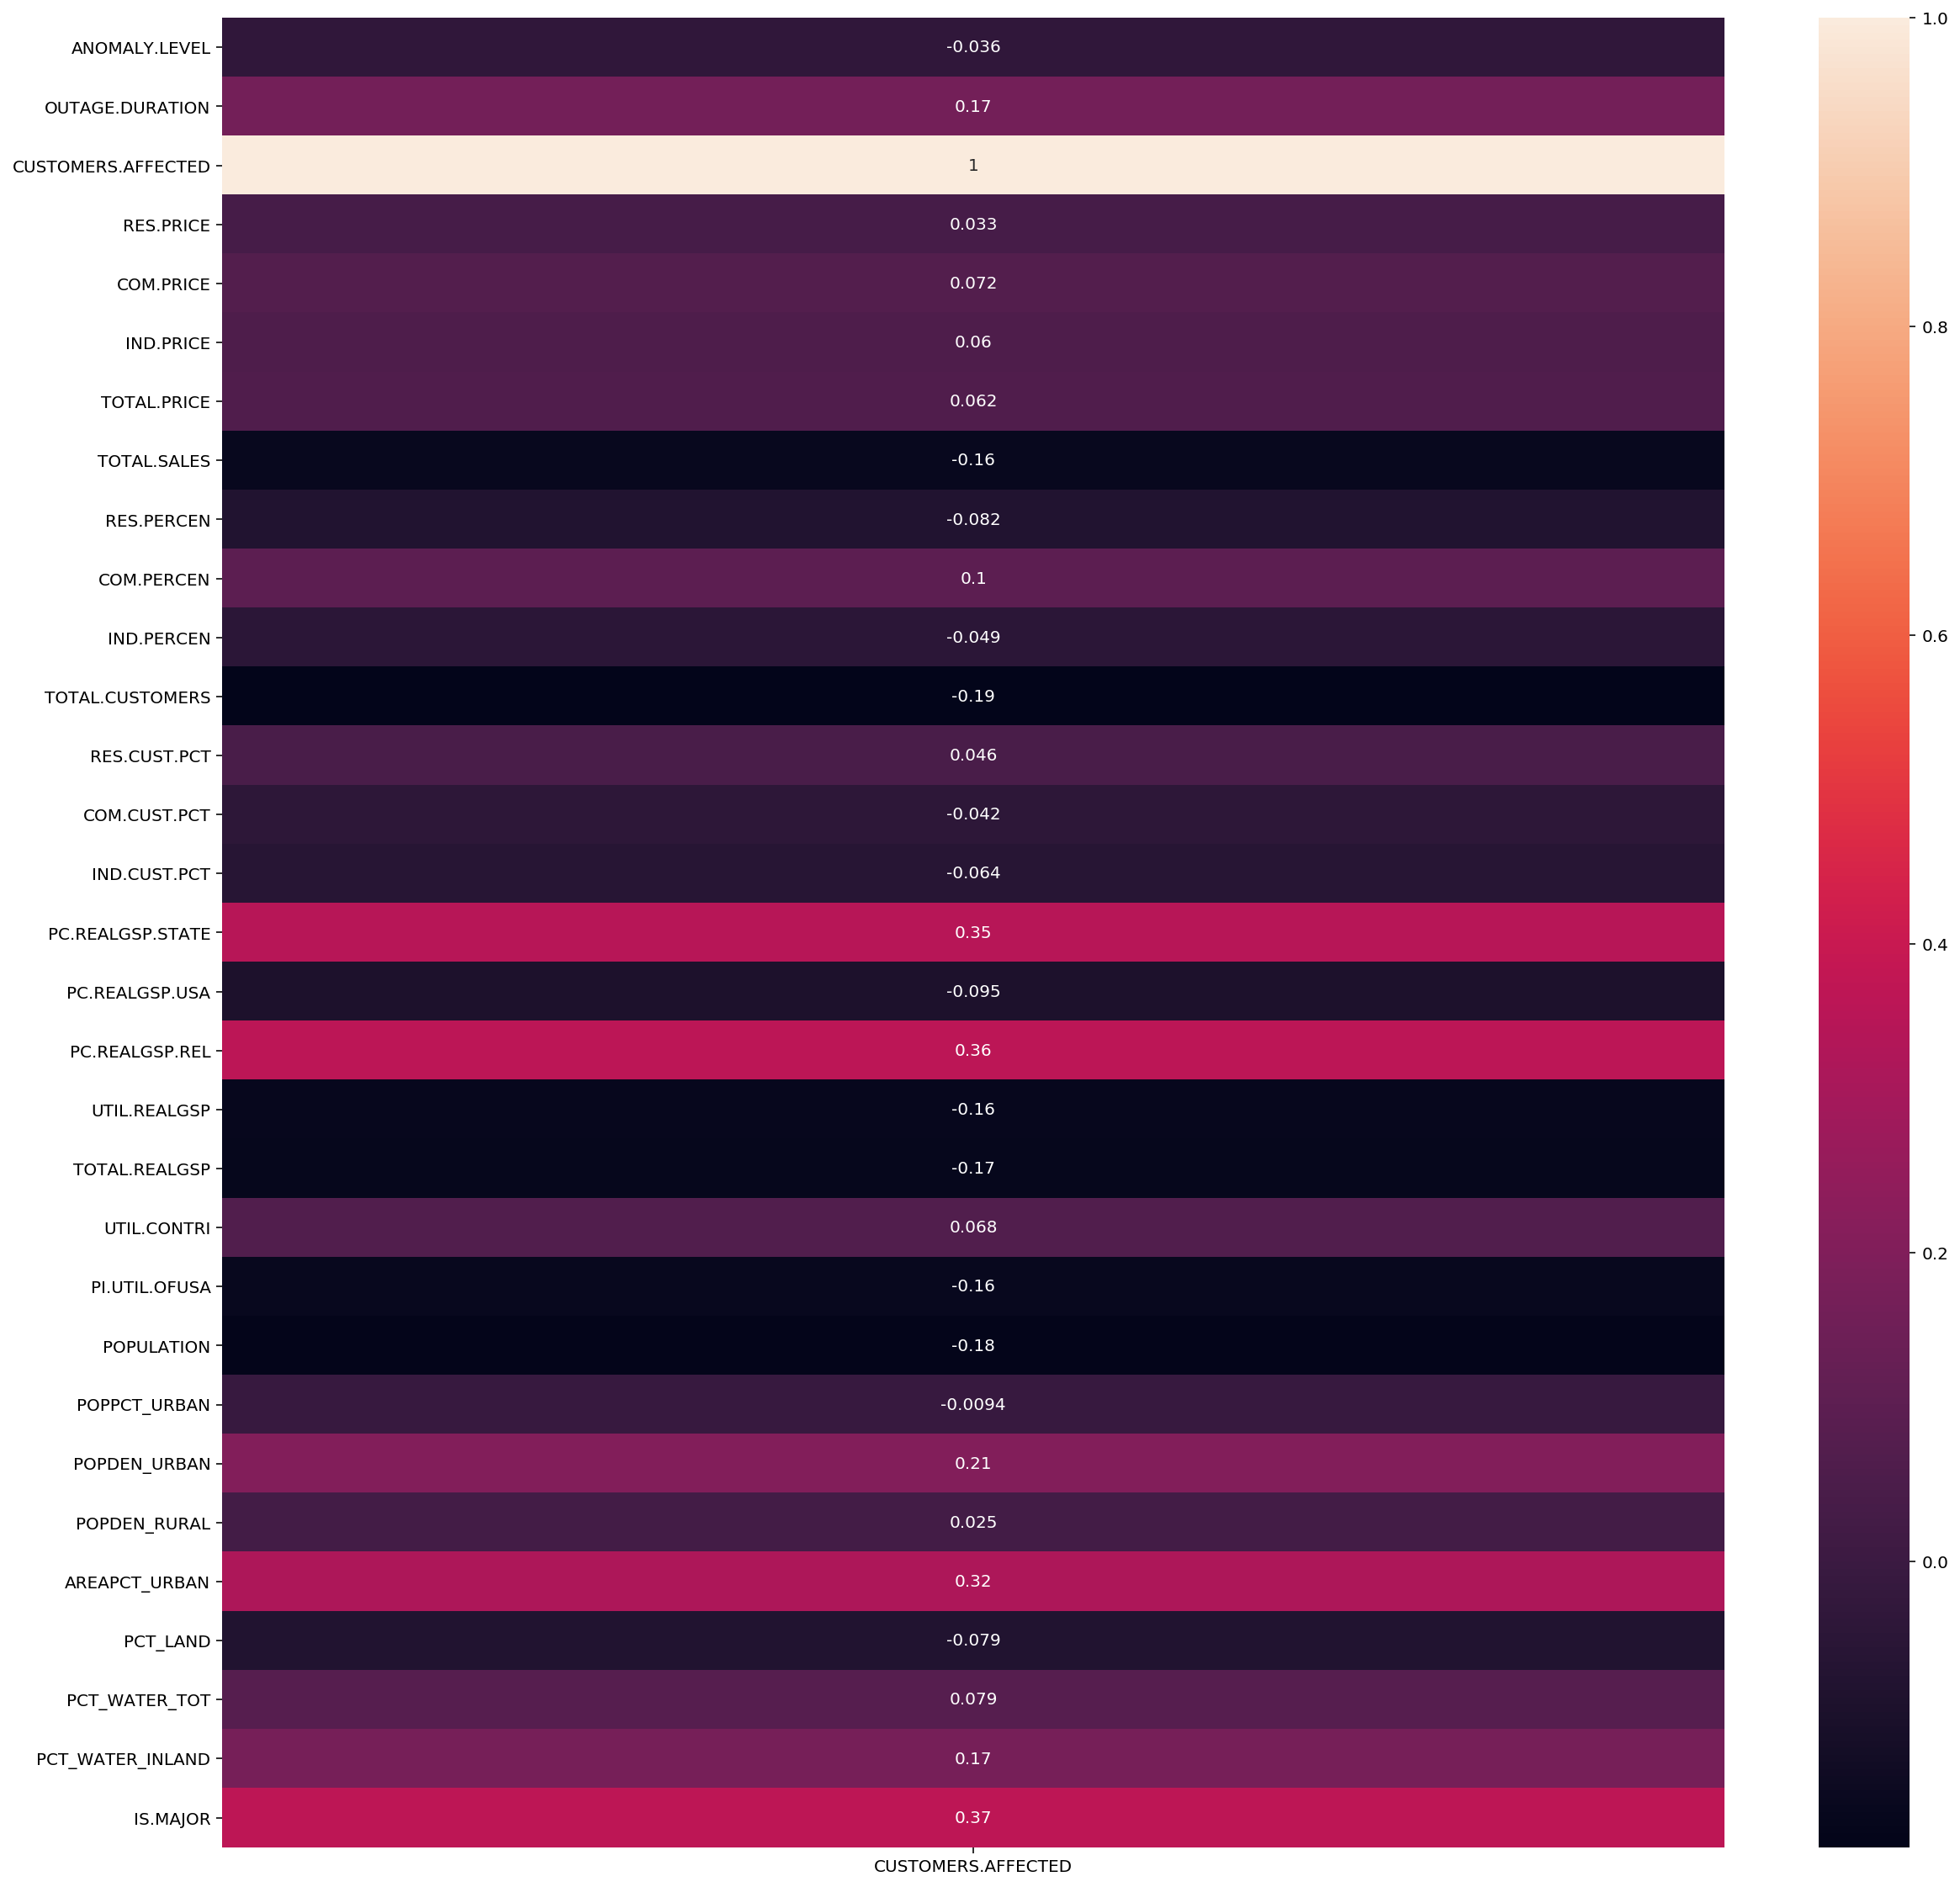

In [18]:

corrMatrix = outage.corr()

fig, ax = plt.subplots(figsize=(20,20)) 

ax = sns.heatmap(corrMatrix[["CUSTOMERS.AFFECTED"]], annot=True) #notation: "annot" not "annote"
y_lims = ax.get_ylim()

ax.set_ylim(sum(y_lims), 0)

In [19]:
POS = ['PC.REALGSP.STATE','PC.REALGSP.REL','POPDEN_URBAN','AREAPCT_URBAN','PCT_WATER_INLAND','OUTAGE.DURATION']
INV = ['TOTAL.SALES','TOTAL.CUSTOMERS','UTIL.REALGSP', 'TOTAL.REALGSP', 'PI.UTIL.OFUSA', 'POPULATION']
USABLE_COLUMNS = POS + INV

SEVCOL_IDX=0

## Baseline Model

array([-8.13875811e+09,  7.06576481e-02, -3.83297580e-01,  2.73624633e-01])

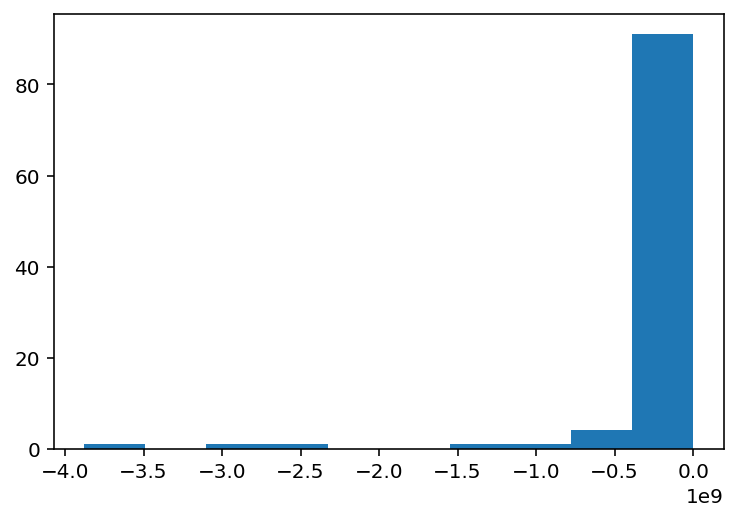

In [20]:
# BASELINE MODEL

# raw and undetailed: 
# numericals are unchanged, but imputed with 0's
# categoricals are imputed with string "NULL", then one-hot encoded

# NO PCA 
outage_df = outage.copy()

severity_columns = ["CUSTOMERS.AFFECTED","OUTAGE.DURATION","DEMAND.LOSS.MW"]
target_col_name = severity_columns[SEVCOL_IDX]
outage_df = outage_df.dropna(subset=[target_col_name])
outage_target = outage_df[target_col_name]
outage_df = outage_df.drop(columns=[target_col_name])

QUANTITATIVE_COLUMNS1 = [col for col in outage_df.columns if level_of_measurements[col]=="Q"]
ORDINAL_COLUMNS1 = [col for col in outage_df.columns if level_of_measurements[col]=="O"]
NOMINAL_COLUMNS1 = [col for col in outage_df.columns if level_of_measurements[col]=="N"]

categ_columns = NOMINAL_COLUMNS1
#numer_columns = QUANTITATIVE_COLUMNS1 + ORDINAL_COLUMNS1
numer_columns = USABLE_COLUMNS

categ_columns_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="constant", fill_value="NULL")),
    ("one-hot", OneHotEncoder(sparse=False,handle_unknown="ignore")),
])

numer_columns_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="constant", fill_value=0))
])


ct0 = ColumnTransformer([
    ("categ",categ_columns_pipeline,categ_columns),
    ("numer",numer_columns_pipeline,numer_columns)
])


MODEL = LinearRegression()
#MODEL = DecisionTreeRegressor()

pl_model = Pipeline([
    ("features", ct0),
    ("model", MODEL)
])

y = outage_target

X = outage_df

X_train, X_test, y_train, y_test = train_test_split(X,y)
#print(X_train.isnull().any().any())
pl_model.fit(X_train, y_train)
score = pl_model.score(X_test, y_test)
    
scores_base = [score]
for _ in range(99):
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    pl_model.fit(X_train, y_train)
    score = pl_model.score(X_test, y_test)
    scores_base.append(score)
plt.hist(scores_base)
cross_val_score(pl_model, X_train, y_train, cv=4)

### Improvements to Model

* This subsection is now about improvements for the model (scroll down further to Final Model to skip this section)
* The list of improvements taken included:
    1. Using PCA to reduce dimensionality and redundant eigenvectors
    2. Engineering new features by putting numerical variables through log transformations
    3. Using GridsearchCv to find optimal pipeline parameters

#### 1. - PCA and Dimensionality Reduction :
* By using PCA, we can potentially reduce the dimensionality and redundant eigenvectors

True


array([0.48589536, 0.15703869, 0.02560319, 0.02809159])

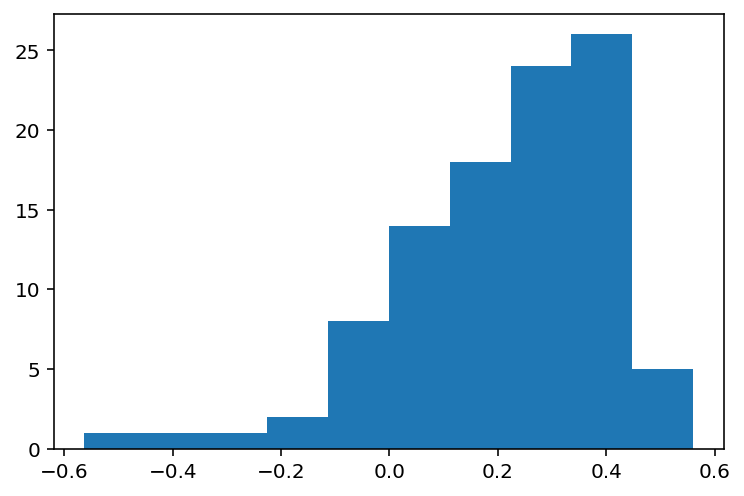

In [21]:
# REGRESSION MODEL with 
# PCA


outage_df = outage.copy()

severity_columns = ["CUSTOMERS.AFFECTED","OUTAGE.DURATION","DEMAND.LOSS.MW"]
target_col_name = severity_columns[SEVCOL_IDX]
outage_df = outage_df.dropna(subset=[target_col_name])
outage_target = outage_df[target_col_name]
outage_df = outage_df.drop(columns=[target_col_name])

QUANTITATIVE_COLUMNS1 = [col for col in outage_df.columns if level_of_measurements[col]=="Q"]
ORDINAL_COLUMNS1 = [col for col in outage_df.columns if level_of_measurements[col]=="O"]
NOMINAL_COLUMNS1 = [col for col in outage_df.columns if level_of_measurements[col]=="N"]

categ_columns = NOMINAL_COLUMNS1
# numer_columns = QUANTITATIVE_COLUMNS1 + ORDINAL_COLUMNS1
numer_columns = USABLE_COLUMNS

categ_columns_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="constant", fill_value="NULL")),
    ("one-hot", OneHotEncoder(sparse=False,handle_unknown="ignore")),
    ("pca", PCA(svd_solver="full"))
])

numer_columns_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="constant", fill_value=0)),
    ("pca", PCA(svd_solver="full"))
])


ct0 = ColumnTransformer([
    ("categ",categ_columns_pipeline,categ_columns),
    ("numer",numer_columns_pipeline,numer_columns)
])


MODEL = LinearRegression()
#MODEL = DecisionTreeRegressor()

pl_model = Pipeline([
    ("features", ct0),
    ("model", MODEL)
])


y = outage_target

X = outage_df

X_train, X_test, y_train, y_test = train_test_split(X,y)
print(X_train.isnull().any().any())
pl_model.fit(X_train, y_train)
score = pl_model.score(X_test, y_test)
    
scores = [score]
for _ in range(99):
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    pl_model.fit(X_train, y_train)
    score = pl_model.score(X_test, y_test)
    scores.append(score)
plt.hist(scores)
cross_val_score(pl_model, X_train, y_train, cv=4)

#### 2. Feature Engineering - Log Transformation
* A lot of the numerical features are non-negative, i.e. bounded between 0 and 1 as percentages or as natural integers from 0 to infinity.
* A lot of them are also **right-skewed**, which makes somewhat sense in real life scenarios, since observations about natural, nonnegative features cluster close to 0 but taper off as x gets bigger

* Applying log-transform to right-skewed data to help make it look more normally distributed
    * NOTE: you need to apply the LogAdjustedScaler to the target column too for this to work!
    * Beforehand, you need to add a constant to the feature to avoid incidents with ln(0), which is undefined.
    * That constant will be log_adjuster = 1.0e-20

array([0.75050743, 0.78018228, 0.65923849, 0.82055623])

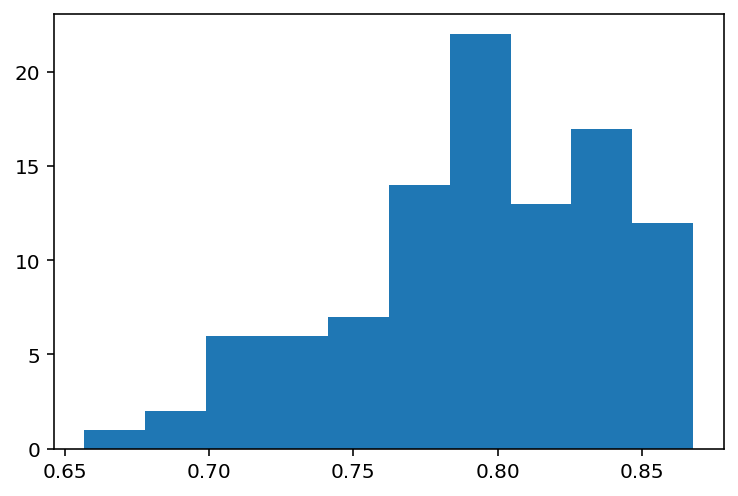

In [22]:
from scipy.stats import skew
def LogAdjustedScaler(x, log_adjuster=1.0e-20):
    if np.any(x< 0):
        return x
    return np.log(x + log_adjuster)

LogAdjustedTransform = FunctionTransformer(LogAdjustedScaler)

# REGRESSION MODEL with 
# PCA
# LOG SCALER

outage_df = outage.copy()

severity_columns = ["CUSTOMERS.AFFECTED","OUTAGE.DURATION","DEMAND.LOSS.MW"]
target_col_name = severity_columns[SEVCOL_IDX]
outage_df = outage_df.dropna(subset=[target_col_name])
outage_target = outage_df[target_col_name].apply(LogAdjustedScaler)
outage_df = outage_df.drop(columns=[target_col_name])

QUANTITATIVE_COLUMNS1 = [col for col in outage_df.columns if level_of_measurements[col]=="Q"]
ORDINAL_COLUMNS1 = [col for col in outage_df.columns if level_of_measurements[col]=="O"]
NOMINAL_COLUMNS1 = [col for col in outage_df.columns if level_of_measurements[col]=="N"]

categ_columns = NOMINAL_COLUMNS1
#numer_columns = QUANTITATIVE_COLUMNS1 + ORDINAL_COLUMNS1
numer_columns = USABLE_COLUMNS

categ_columns_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="constant", fill_value="NULL")),
    ("one-hot", OneHotEncoder(sparse=False,handle_unknown="ignore")),
    ("pca", PCA(svd_solver="full"))
])

numer_columns_pipeline = Pipeline([
    ("log", LogAdjustedTransform),
    ("imp", SimpleImputer(strategy="constant", fill_value=0)),
    ("pca", PCA(svd_solver="full"))
])


ct0 = ColumnTransformer([
    ("categ",categ_columns_pipeline,categ_columns),
    ("numer",numer_columns_pipeline,numer_columns)
])


MODEL = LinearRegression()
#MODEL = DecisionTreeRegressor()

pl_model = Pipeline([
    ("features", ct0),
    ("model", MODEL)
])

y = outage_target

X = outage_df

np.random.seed(10)
X_train, X_test, y_train, y_test = train_test_split(X,y)
#print(X_train.isnull().any().any())
pl_model.fit(X_train, y_train)
score = pl_model.score(X_test, y_test)
    
scores = [score]
for _ in range(99):
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    pl_model.fit(X_train, y_train)
    score = pl_model.score(X_test, y_test)
    scores.append(score)
plt.hist(scores)
cross_val_score(pl_model, X_train, y_train, cv=4)

##### The histogram of scores really improved! :D

In [23]:
scores1 = []
for i in range(100):
    np.random.seed(i)
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    pl_model.fit(X_train, y_train)
    score = pl_model.score(X_test, y_test)
    scores1.append(score)

# finding the best seed for train_test_split    

good_seed = scores1.index(max(scores1))
np.random.seed(good_seed)
X_train, X_test, y_train, y_test = train_test_split(X,y)
pl_model.fit(X_train, y_train)
pl_model.score(X_test, y_test)

0.9062652915888897

### 3. GridsearchCV to find optimal parameters
* We need to use GridsearchCV to find optimal parameters

In [24]:
#GRID-SEARCHING

n_components_range = [0.25, 0.50, 0.75, None]
scenario1 = {"features__categ__pca__n_components":n_components_range,
             "features__numer__pca__n_components":[1,3,5,10]}
params_list = [
    scenario1
]

outage_df1 = outage.copy()

severity_columns = ["CUSTOMERS.AFFECTED","OUTAGE.DURATION","DEMAND.LOSS.MW"]
target_col_name = severity_columns[SEVCOL_IDX]
outage_df1 = outage_df1.dropna(subset=[target_col_name])

outage_target = outage_df1[target_col_name].apply(LogAdjustedScaler)


outage_df1 = outage_df1[categ_columns + numer_columns]
gy = outage_target

gX = outage_df1

gX_train, gX_test, gy_train, gy_test = train_test_split(gX,gy)

grids = GridSearchCV(pl_model, params_list)

grids.fit(gX_train, gy_train)

grids.best_params_

{'features__categ__pca__n_components': None,
 'features__numer__pca__n_components': 1}

## Final Model

cross_val_score: [0.7480612  0.79714618 0.6674096  0.81308358]


Text(0.5, 1.0, "Final and Improved Model's Histogram of Correlation Scores")

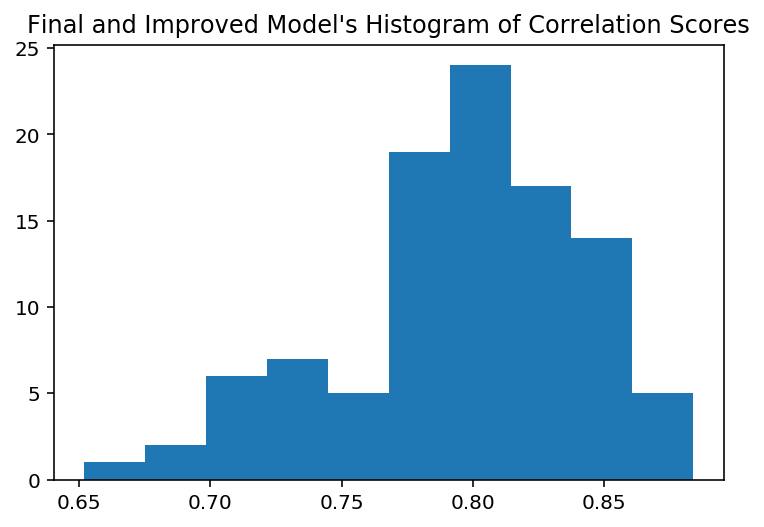

In [34]:
# while still using log adjust
# but not right skew

def LogAdjustedScaler(x, log_adjuster=1.0e-20):
    if np.any(x< 0):
        return x
    return np.log(x + log_adjuster)

LogAdjustedTransform = FunctionTransformer(LogAdjustedScaler)

outage_df = outage.copy()

target_col_name = "CUSTOMERS.AFFECTED"
outage_df = outage_df.dropna(subset=[target_col_name])
outage_target = outage_df[target_col_name].apply(LogAdjustedScaler)
outage_df = outage_df.drop(columns=[target_col_name])


NOMINAL_COLUMNS1 = [col for col in outage_df.columns if level_of_measurements[col]=="N"]

categ_columns = NOMINAL_COLUMNS1
numer_columns = USABLE_COLUMNS

categ_columns_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="constant", fill_value="NULL")),
    ("one-hot", OneHotEncoder(sparse=False,handle_unknown="ignore")),
    ("pca", PCA(svd_solver="full",n_components=None))
])
numer_columns_pipeline = Pipeline([
    ("log", LogAdjustedTransform),
    ("imp", SimpleImputer(strategy="constant", fill_value=0)),
    ("pca", PCA(svd_solver="full", n_components=1))
])

ct0 = ColumnTransformer([
    ("categ",categ_columns_pipeline,categ_columns),
    ("numer",numer_columns_pipeline,numer_columns)
])

MODEL = LinearRegression()

pl_model = Pipeline([
    ("features", ct0),
    ("model", MODEL)
])

y = outage_target

X = outage_df

np.random.seed(10)
X_train, X_test, y_train, y_test = train_test_split(X,y)
pl_model.fit(X_train, y_train)
score = pl_model.score(X_test, y_test)
    
scores = [score]
for _ in range(99):
    X_train, X_test, y_train, y_test = train_test_split(X,y)
    pl_model.fit(X_train, y_train)
    score = pl_model.score(X_test, y_test)
    scores.append(score)
plt.hist(scores)
print("cross_val_score:", cross_val_score(pl_model, X_train, y_train, cv=4))
plt.title("Final and Improved Model's Histogram of Correlation Scores")

#### For comparison, revisit the baseline model's histogram of scores:

Text(0.5, 1.0, "Original Baseline Model's Score Histogram of Correlation Scores")

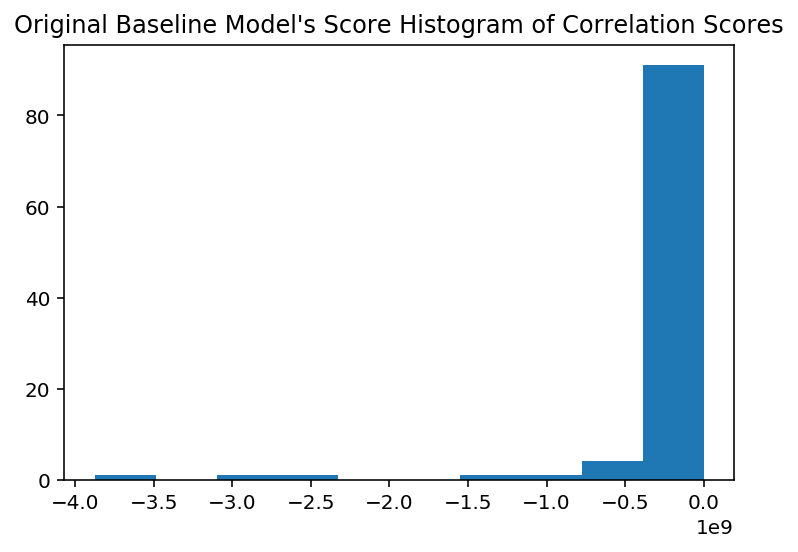

In [35]:
plt.hist(scores_base)
plt.title("Original Baseline Model's Score Histogram of Correlation Scores")

## Fairness Evaluation

* Now that we've created a model that predicts the (log-scaled) percentage of customers in a state that gets affected by a power outage, we need to see if our model is fair on the state's urban population percentage

In [27]:
results = X_test.copy()
predictions = (pl_model.predict(X_test))
prediction_target_colname = "PREDICTED.CUSTOMERS.AFFECTED"
actual_target_colname = "TARGET.CUSTOMERS.AFFECTED"
results[prediction_target_colname] = predictions
results[actual_target_colname] = outage_target

In [28]:
FAIRNESS_GROUPBY_COL_NAME = "POPPCT_URBAN"
FAIRNESS_GROUPBY_COL = outage_df[FAIRNESS_GROUPBY_COL_NAME] >= 0.5
def get_RMSE(a, b):
    return np.sqrt(np.mean((a-b)**2))
def FAIRNESS_GROUPBY_FUNCTION(df):
    return get_RMSE(df[prediction_target_colname],df[actual_target_colname])

In [29]:
# DEMOGRAPHICS PARITY
(
    results
    .groupby(FAIRNESS_GROUPBY_COL)
    .apply(FAIRNESS_GROUPBY_FUNCTION)
    .rename("RMSE")
    .to_frame()
)

,RMSE
POPPCT_URBAN,
False,11.620023
True,6.205598


#### Parity
* From the looks of things, the model might not be fair to less-urbanized populations, since the RMSE is higher for observations where the POPPCT_URBAN < 0.5, where POPPCT_URBAN is the percentage of a state population that is urban at the time of a given outage. But more testing is needed to make clear judgements.

#### Permutation Testing
* Permutation testing with significance level = 0.05
* Part 1. Test statistic is absolute difference of RMSE
* Part 2. Test statistic is absolute difference of correlation coefficient
* Column being permuted is the POPPCT_URBAN, and then afterwards divided as above 50% or not

In [30]:
# part 1- Test statistic is absolute difference of RMSE
Sign_level = 0.05
obs = results.groupby(FAIRNESS_GROUPBY_COL_NAME).apply(lambda temp_df:
        get_RMSE(
            temp_df[prediction_target_colname],
            temp_df[actual_target_colname]
        )
    ).diff().iloc[-1]
obs = np.abs(obs)
metrs = []
temp_df0 = results[[FAIRNESS_GROUPBY_COL_NAME, prediction_target_colname, actual_target_colname]]
for _ in range(1000):
    temp_df = temp_df0.copy()
    # reshuffle
    temp_df[FAIRNESS_GROUPBY_COL_NAME] = temp_df[FAIRNESS_GROUPBY_COL_NAME].sample(frac=1.0, replace=False).values
    #
    TEMP_FAIRNESS_GROUPBY_COL = (temp_df[FAIRNESS_GROUPBY_COL_NAME] >= 0.5).values
    x = temp_df.groupby(TEMP_FAIRNESS_GROUPBY_COL).apply(lambda temp_df:
        get_RMSE(
            temp_df[prediction_target_colname],
            temp_df[actual_target_colname]
        )
    ).diff().iloc[-1]  
    metrs.append(np.abs(x))

0.713


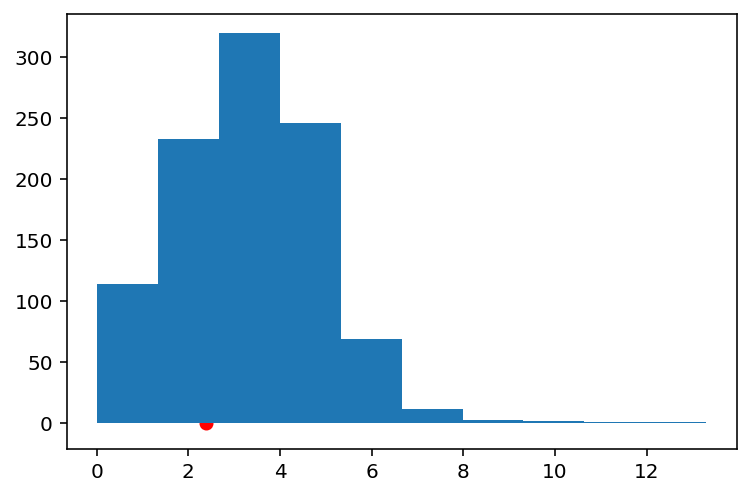

In [31]:
print(pd.Series(np.abs(np.array(metrs)) >= (obs)).mean())
#pd.Series(metrs).plot(kind='hist', title='Permutation Test for Customer Affected percentages across NERC regions')
plt.hist(metrs)
plt.scatter(obs, 0.1, c='r');

In [32]:
# Part 2. Test statistic is absolute difference of correlation coefficient

from scipy.stats import linregress
def get_R2(a, b):
    return linregress(a, b).rvalue

Sign_level = 0.05
obs2 = results.groupby(FAIRNESS_GROUPBY_COL_NAME).apply(lambda temp_df:
        get_R2(
            temp_df[prediction_target_colname],
            temp_df[actual_target_colname]
        )
    ).diff().iloc[-1]
obs2 = np.abs(obs2)
metrs2 = []
temp_df0 = results[[FAIRNESS_GROUPBY_COL_NAME, prediction_target_colname, actual_target_colname]]
for _ in range(1000):
    temp_df = temp_df0.copy()
    # reshuffle
    temp_df[FAIRNESS_GROUPBY_COL_NAME] = temp_df[FAIRNESS_GROUPBY_COL_NAME].sample(frac=1.0, replace=False).values
    #
    TEMP_FAIRNESS_GROUPBY_COL = (temp_df[FAIRNESS_GROUPBY_COL_NAME] >= 0.5).values
    x = temp_df.groupby(TEMP_FAIRNESS_GROUPBY_COL).apply(lambda temp_df:
        get_R2(
            temp_df[prediction_target_colname],
            temp_df[actual_target_colname]
        )
    ).diff().iloc[-1]  
    metrs2.append(np.abs(x))

c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_stats_mstats_common.py:174: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_distn_infrastructure.py:2007: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\_stats_mstats_common.py:176: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


0.238


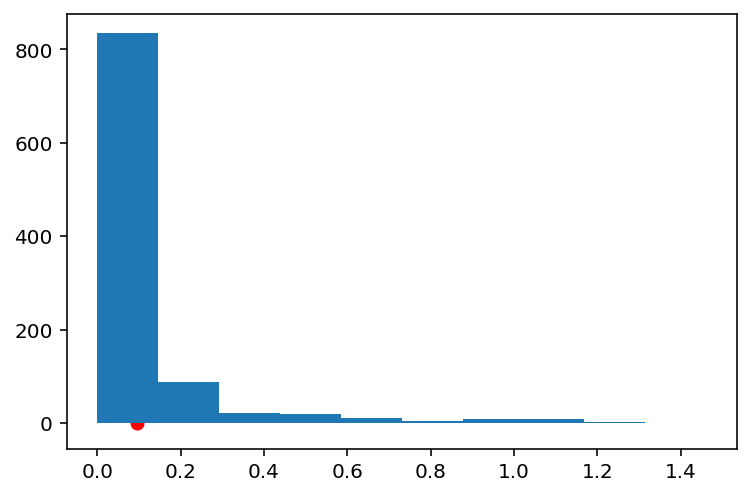

In [33]:
print(pd.Series(np.abs(np.array(metrs2)) >= (obs2)).mean())
#pd.Series(metrs).plot(kind='hist', title='Permutation Test for Customer Affected percentages across NERC regions')
plt.hist(metrs2)
plt.scatter(obs2, 0.1, c='r');

#### Hypothesis Testing
* Null Hypothesis: the RMSE of predicted vs actual (logged) customer-affected rates is roughly identical between states with >50% urbanized populations vs <50% urbanized populations.
*  Alternative Hypothesis: the RMSE of predicted vs actual (logged) customer-affected rates is **NOT** roughly identical between states with >50% urbanized populations vs <50% urbanized populations.

#### Conclusion
* We fail to reject the Null Hypothesis. Even when using 2 different test statistics, namely Absolute difference of RMSE and  Absolute difference of correlation coefficient, the pvalues are still both immensely greater than the significance level 0.05, being roughly 0.76 and 0.2 respectively
Thus, the project's model is probably fair for urbanized and non-urbanized populations